# Dataset

In [1]:
from discopy import Functor, Ty, Word, Id, Cup

class WordBox(Word):
    """ Word with Ty((name, cod)) as domain. """
    def __init__(self, name, cod):
        super().__init__(name, cod, dom=Ty((name, cod)))


def remove(word, sentence):
    """
    Takes a WordBox and a sentence, replaces that box by an identity,
    and every other WordBoxes by a standard Word with empty domain.
    """
    def ob(x):
        obj, = x
        if not isinstance(obj.name, tuple):
            return x  # Standard types get mapped to themselves.
        if obj.name == (word.name, word.cod):
            return word.cod
        return Ty()  # Normal words have empty dom.

    def ar(f):
        if f == word:
            return Id(word.cod)
        return Word(f.name, f.cod)
    return Functor(ob, ar)(sentence)

# vocab
s, n = Ty('s'), Ty('n')
tv = n.r @ s @ n.l
iv = n.r @ s
p = s.r @ n.r.r @ n.r @ s @ n.l

vocab = {
    n: ["dog", "cat", "mouse", "fox", "chicken", "grain", "cheese", "bone", "fish", "whale", "seal", "krill", "water", "land"],
    tv: ["chases", "flees", "bites", "eats"],
    iv: ["barks", "meows", "squeaks", "clucks", "chases", "runs", "swims"],
     p: ["at", "after", "in", "on"]
}

# grammars
grammars = [Cup(n, n.r) @ Id(s),
            Cup(n, n.r) @ Id(s) @ Cup(n.l, n), 
            (Id(n) @ Id(n.r) @ Cup(s, s.r) @ Id(n.r.r) @ Id(n.r) >> Id(n) @ Cup(n.r, n.r.r) @ Id(n.r) >> Cup(n, n.r)) @ Id(s) @ Cup(n.l, n)]

# transitive sentences (grammars[1])
trans_corpus = {
    "dog": {
        "chases": ["cat", "fox"],
        "bites": ["cat", "fox", "bone"],
        "eats": ["bone"]
    },
    "cat": {
        "chases": ["mouse"],
        "flees": ["dog"],
        "bites": ["mouse", "fish"],
        "eats": ["fish"]
    },
    "mouse": {
        "flees": ["cat"],
        "bites": ["cheese"],
        "eats": ["cheese"]
    },
    "fox": {
        "chases": ["chicken"],
        "flees": ["dog"],
        "bites": ["chicken"],
        "eats": ["chicken"]
    },
    "chicken": {
        "flees": ["fox"],
        "eats": ["grain"]
    },
    "whale": {
        "eats": ["krill"]
    },
    "seal": {
        "eats": ["fish"]
    }
}

# intransitive sentences (grammars[0, 2])
itrans_corpus = {
    "dog": {
        "runs": {
            "on": ["land"],
            "after": ["cat", "fox"]
        },
        "chases": {
            "after": ["cat", "fox"]
        },
        "barks": {
            "at": ["cat", "fox"]
        }
      },
      "cat": {
          "runs": {
              "on": ["land"],
              "after": ["mouse"]
          },
          "chases": {
              "after": ["mouse"]
          },
          "meows": { }
      },
      "mouse": {
          "runs": {
              "on": ["land"]
          },
          "squeaks": { }
      },
      "fox": {
          "runs": {
              "on": ["land"],
              "after": ["chicken"]
          },
          "chases": {
              "after": ["chicken"]
          }
      },
      "chicken": {
          "runs": {
              "on": ["land"]
          },
          "clucks": { }
      },
      "fish": {
          "swims": {
              "in": ["water"]
          }
      },
      "whale": {
          "swims": {
              "in": ["water"]
          }
      },
      "seal": {
          "swims": {
              "in": ["water"]
          },
          "runs": {
              "on": ["land"]
          }
      },
}

# data format: { sentence: (diagram, type, word : str) }
dataset = {}
for subj, verb_dict in trans_corpus.items():
  subj_box = WordBox(subj, n)
  for verb, dobjs in verb_dict.items():
    verb_box = WordBox(verb, tv)
    for dobj in dobjs:
      dobj_box = WordBox(dobj, n)
      diagram = subj_box @ verb_box @ dobj_box >> grammars[1]
      dataset[f"{subj} {verb} ?"] = (remove(dobj_box, diagram), dobj_box.cod, dobj)
      dataset[f"{subj} ? {dobj}"] = (remove(verb_box, diagram), verb_box.cod, verb)

    
for subj, verb_dict in itrans_corpus.items():
  subj_box = WordBox(subj, n)
  for verb, prep_dict in verb_dict.items():
    verb_box = WordBox(verb, iv)
    diagram = subj_box @ verb_box >> grammars[0]
    dataset[f"{subj} ?"] = (remove(verb_box, diagram), verb_box.cod, verb)
    dataset[f"? {verb}"] = (remove(subj_box, diagram), subj_box.cod, subj)

    for prep, idobjs in prep_dict.items():
      prep_box = WordBox(prep, p)
      for idobj in idobjs:
        idobj_box = WordBox(idobj, n)
        diagram = subj_box @ verb_box @ prep_box @ idobj_box >> grammars[2]
        dataset[f"? {verb} {prep} {idobj}"] = (remove(subj_box, diagram), subj_box.cod, subj)
        dataset[f"{subj} ? {prep} {idobj}"] = (remove(verb_box, diagram), verb_box.cod, verb)
        dataset[f"{subj} {verb} ? {idobj}"] = (remove(prep_box, diagram), prep_box.cod, prep)
        dataset[f"{subj} {verb} {prep} ?"] = (remove(idobj_box, diagram), idobj_box.cod, idobj)

# JAX

In [2]:
import jax.numpy as jnp
import jax.random as random
from jax import grad, jit
import jax.nn as jnn
import jax.experimental.optimizers as jaxopt

key = random.PRNGKey(0)

# Functorial Model

In [3]:
from functools import partial

from discopy.tensor import Functor as TensorFunctor


def random_orthogonal(key, shape):
    """ If shape is square, uses singular value decomposition
    to generate a random orthogonal matrix. Otherwise, returns
    a rectangular matrix with a high rate of orthogonal rows
    and columns. Worked well empirically. """
    
    H = random.normal(key, shape)
    u, s, vh = jnp.linalg.svd(H, full_matrices=False)
    O = u @ vh
    return O


class Functorial_Model:
    def update_func(self): raise Exception('Not implemented.')
    def loss_func(self): raise Exception('Not implemented.')
    def acc_func(self): raise Exception('Not implemented.')
    def predict_func(self): raise Exception('Not implemented.')

        
class FLM(Functorial_Model):
    
    def __init__(self, vocab, enc_dims, initializer=random_orthogonal):
        
        self.vocab = vocab
        
        self.encoding_matrices = {
            ty: initializer(key, shape=(len(vocab[ty]), enc_dims[ty]))
            for ty in vocab.keys()
        }

        self.functor = self.init_functor()
    
    
    # Old optimizer implementation - now using jax optimizers
    # @partial(jit, static_argnums=(0,))
    # def update_func(self, params, X, y, learn_rate=0.3, **kwargs):
    #     grads = grad(self.loss_func)(params, X, y, **kwargs)
    #     return params - learn_rate * grads
    
    
    @staticmethod
    @jit
    def loss_func(params, X, y, l1_reg=1e-2, l2_reg=1e-3, **kwargs):
        """ Cross Entropy Loss with Regularization
        Uses jax's log_softmax (which implements "logsumexp trick")
        for numerical stability.
        """
        return (-jnp.sum(y * jnn.log_softmax(X @ params.T, -1))
                + l1_reg*jnp.sum(params)
                + l2_reg*jnp.linalg.norm(params, ord="fro"))


    @partial(jit, static_argnums=(0,))
    def acc_func(self, params, X, y):
      """
      Accuracy is based prediction == label.
      Note this is not strictly correct, since there might
      be multiple valid predictions for the same diagram,
      while a parsing of real-world data would only yield
      a single label.
      """
      predicted_class = jnp.argmax(self.predict_func(params, X), axis=-1)
      target_class = jnp.argmax(y, axis=-1)
      return jnp.mean(predicted_class == target_class)
    
    
    @staticmethod
    @jit
    def predict_func(params, X):
        """ Softmax of Activations
        Returns probability distribution over vocab.
        """
        return jnn.softmax(X @ params.T, -1)
    
    
    def init_functor(self):
        """ Initializes the functor. """
        # second dimensions of encoding matrices define object mapping
        obj_map = {
            ty: self.encoding_matrices[ty].shape[1] for ty in self.encoding_matrices.keys()
        }
        obj_map.update({s: 1})

        # rows of encoding matrices define word vectors
        arr_map = { }
        for ty in self.vocab.keys():
            arr_map.update({
                Word(word, ty): self.encoding_matrices[ty][self.vocab[ty].index(word)]
                for word in self.vocab[ty]
            })

        return TensorFunctor(obj_map, arr_map)


    def _update_functor(self, word_type):
      """
      Updates the functor for a given grammatical type.
      """
      self.functor.ar.update({
                Word(word, word_type): self.encoding_matrices[word_type][self.vocab[word_type].index(word)]
                for word in self.vocab[word_type]
            })
    

    def update_FLM(self, word_type, new_matrix):
      """
      Updates both the encoding matrix and functor for a given grammatical type.
      Use for consistency instead of _update_functor alone.
      """
      self.encoding_matrices.update({ word_type: new_matrix })
      self._update_functor(word_type)


# Utility Functions

In [4]:
def preprocess(dataset, vocab, split=0.8):
    """
    Return train-test split data in the form:
    { type: [[diagrams], [labels], [sentences]] }
    """
    preproc = { t: [[], [], []] for t in vocab.keys() }
    train = { t: [[], [], []] for t in vocab.keys() }
    test = { t: [[], [], []] for t in vocab.keys() }
    
    for sentence, (diagram, word_type, word) in dataset.items():
        preproc[word_type][0].append(diagram)
        
        label = jnp.array([i == vocab[word_type].index(word) for i in range(len(vocab[word_type]))])
        preproc[word_type][1].append(label)

        preproc[word_type][2].append(sentence)

    # train test split
    for word_type, [diagrams, labels, sentences] in preproc.items():
        indices = random.permutation(key, len(diagrams))
        max_train_idx = int(0.8*len(diagrams))
        train_indices = indices[:max_train_idx]
        test_indices = indices[max_train_idx:]
        
        train[word_type][0] = [diagrams[i] for i in train_indices]
        train[word_type][1] = jnp.array([labels[i] for i in train_indices])
        train[word_type][2] = [sentences[i] for i in train_indices]
        test[word_type][0] = [diagrams[i] for i in test_indices]
        test[word_type][1] = jnp.array([labels[i] for i in test_indices])
        test[word_type][2] = [sentences[i] for i in test_indices]
    
    return train, test


def fit(model, train_data, test_data=None, opt=jaxopt.sgd(5e-2), opt_steps=10, epochs=9, report_every=3, **kwargs):
    """
    Fits the model with configurable hyperparameters.
    Loss function also takes l1_reg and l2_reg parameters, which can be passed in via kwargs.
    """

    for epoch in range(epochs):     
        loss = 0
        acc = 0
        acc_div = 0
        for word_type, (diagrams, labels, _) in train_data.items():
            # from grammar to tensor
            F = model.functor
            X = jnp.array([F(diagram).array for diagram in diagrams])
            # for transitive verbs
            X = jnp.reshape(X, (len(diagrams), -1))
            

            # the update step
            # JAX optimizers, use commented out "update_func" for ordinary gradient descent
            opt_init, opt_update, get_params = opt
            opt_state = opt_init(model.encoding_matrices[word_type])

            def opt_step(step, opt_state, X, labels, **kwargs):
              grads = grad(model.loss_func)(get_params(opt_state), X, labels, **kwargs)
              opt_state = opt_update(step, grads, opt_state)
              return opt_state

            for step in range(opt_steps):
              opt_state = opt_step(step, opt_state, X, labels, **kwargs)

            # update the FLM
            model.update_FLM(word_type, opt_state.packed_state[0][0])
            
            # --- OLD OPTIMIZATION --- #
            # new_matrix = model.update_func(
            #     model.encoding_matrices[word_type], X, labels, **kwargs
            # )
            # model.encoding_matrices.update({ word_type: new_matrix })
            # ------------------------ #

            if (epoch + 1) % report_every == 0:
              # metrics
              # normalize loss for train-test comparison
              acc += model.acc_func(model.encoding_matrices[word_type], X, labels)
              loss += model.loss_func(model.encoding_matrices[word_type], X, labels)/X.shape[0]
              acc_div += 1

        if (epoch+1) % report_every == 0:
                print(f"training loss after {epoch+1} epochs: {loss}")
                print(f"training accuracy after {epoch+1} epochs: {acc/acc_div}\n")
                if test_data:
                  test_loss = 0
                  test_acc = 0
                  test_acc_div = 0
                  for word_type, (diagrams, labels, _) in test_data.items():
                    # same as above w/o update
                    F = model.functor
                    X = jnp.array([F(diagram).array for diagram in diagrams])
                    X = jnp.reshape(X, (len(diagrams), -1))
                    test_acc += model.acc_func(model.encoding_matrices[word_type], X, labels)
                    test_loss += model.loss_func(model.encoding_matrices[word_type], X, labels)/X.shape[0]
                    test_acc_div += 1
                  print(f"test loss: {test_loss}")
                print(f"test accuracy: {test_acc/test_acc_div}\n")


def show_results(model, *datasets):
    F = model.functor
    for dataset in datasets:
      for word_type, (diagrams, labels, sentences) in dataset.items():
          for diagram, label, sentence in zip(diagrams, labels, sentences):
              x = jnp.array(F(diagram).array)

              # for transitive verbs
              x = jnp.reshape(x, (-1,))

              probs = model.predict_func(
                  model.encoding_matrices[word_type], x
              )
              pred = vocab[word_type][int(jnp.argmax(probs))]
              (Word("?", word_type) >> diagram).draw(figsize=(6,3))
              actual = vocab[word_type][jnp.argmax(label)]
              print(f"sentence: {sentence}\nprediction: {pred} | actual: {actual}")
              print(f"\ntop probabilities:")
              for i in jnp.argsort(probs)[-1:-5:-1]:
                  print(f"  {vocab[word_type][i]}: {probs[i]:.2f}")
              print("------------------\n")


def show_results_compact(model, *datasets):
    F = model.functor
    for dataset in datasets:
      for word_type, (diagrams, labels, sentences) in dataset.items():
        for diagram, label, sentence in zip(diagrams, labels, sentences):
            x = jnp.array(F(diagram).array)

            # for transitive verbs
            x = jnp.reshape(x, (-1,))

            probs = model.predict_func(
                model.encoding_matrices[word_type], x
            )
            pred = vocab[word_type][int(jnp.argmax(probs))]
            actual = vocab[word_type][jnp.argmax(label)]

            print(f"{sentence}:  {pred} ({actual})")
            top_probs = ', '.join(
                      [f"{vocab[word_type][i]}: {probs[i]:.2f}"
                      for i in jnp.argsort(probs)[-1:-3:-1]]
                      )
            print(f"[top probabilities: {top_probs}]")
            print("--------------")

# Trying it out!

In [5]:
# initialize the FLM
noun_dim = len(vocab[n]) // 2
enc_dims = {
    n: noun_dim,
    tv: noun_dim ** 2,
    iv: noun_dim,
    p: noun_dim ** 3
}
# try different initializations e.g. jnn.initializers.he_normal()
# https://jax.readthedocs.io/en/latest/jax.nn.initializers.html
flm = FLM(vocab, enc_dims, initializer=random_orthogonal)

# get training and testing data
train_data, test_data = preprocess(dataset, vocab)

# JAX optimizer
step_size=5e-2
# try different optimization algos e.g. jaxopt.sgd(step_size)
# https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html
opt = jaxopt.adam(step_size)

# fit the model
# try messing around with the hyperparameters
fit(flm, train_data, test_data, opt=opt, opt_steps=10, l1_reg=0.1, l2_reg=5e-2, epochs=5, report_every=1)

training loss after 1 epochs: 3.8713934421539307
training accuracy after 1 epochs: 0.682539701461792

test loss: 5.8964338302612305
test accuracy: 0.47196972370147705

training loss after 2 epochs: 1.134953498840332
training accuracy after 2 epochs: 0.863095223903656

test loss: 2.5842647552490234
test accuracy: 0.6030303239822388

training loss after 3 epochs: 0.08608520030975342
training accuracy after 3 epochs: 0.8948412537574768

test loss: 3.1037299633026123
test accuracy: 0.6738636493682861

training loss after 4 epochs: -0.15781939029693604
training accuracy after 4 epochs: 0.8690475821495056

test loss: 0.24258899688720703
test accuracy: 0.6284090876579285

training loss after 5 epochs: -0.8782056570053101
training accuracy after 5 epochs: 0.9007936716079712

test loss: -4.0811944007873535
test accuracy: 0.7590909004211426



# Testing on _Unseen_ Sentences

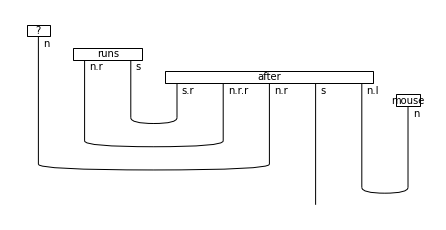

sentence: ? runs after mouse
prediction: cat | actual: cat

top probabilities:
  cat: 0.96
  fox: 0.03
  seal: 0.00
  water: 0.00
------------------



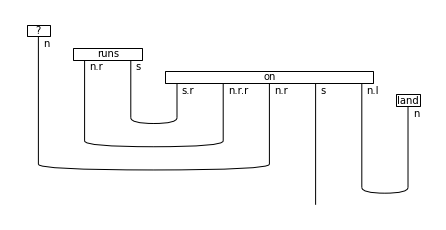

sentence: ? runs on land
prediction: land | actual: seal

top probabilities:
  land: 0.73
  mouse: 0.13
  dog: 0.05
  water: 0.04
------------------



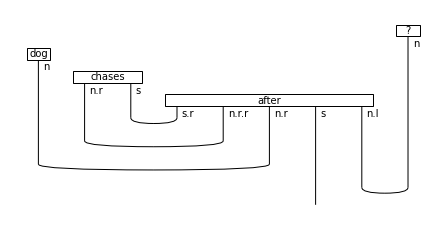

sentence: dog chases after ?
prediction: cat | actual: fox

top probabilities:
  cat: 1.00
  fox: 0.00
  seal: 0.00
  land: 0.00
------------------



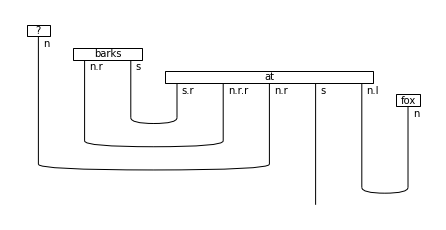

sentence: ? barks at fox
prediction: dog | actual: dog

top probabilities:
  dog: 0.88
  land: 0.12
  water: 0.00
  mouse: 0.00
------------------



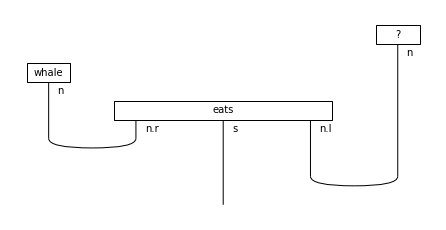

sentence: whale eats ?
prediction: cheese | actual: krill

top probabilities:
  cheese: 0.53
  fish: 0.17
  grain: 0.10
  bone: 0.05
------------------



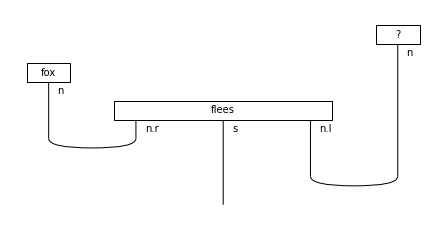

sentence: fox flees ?
prediction: dog | actual: dog

top probabilities:
  dog: 0.92
  land: 0.04
  cheese: 0.03
  fish: 0.01
------------------



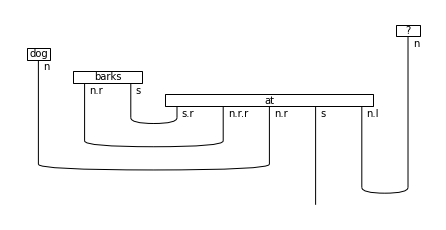

sentence: dog barks at ?
prediction: fox | actual: fox

top probabilities:
  fox: 0.95
  cat: 0.05
  land: 0.00
  krill: 0.00
------------------



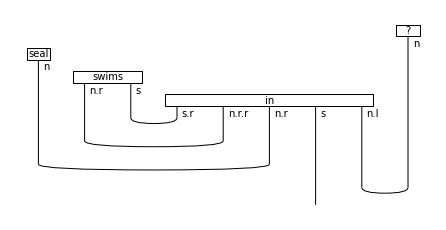

sentence: seal swims in ?
prediction: water | actual: water

top probabilities:
  water: 0.97
  dog: 0.02
  mouse: 0.01
  seal: 0.00
------------------



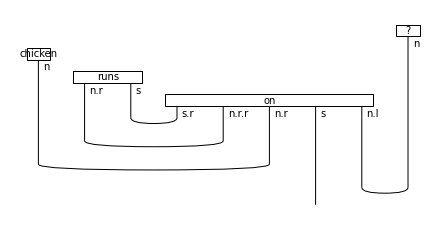

sentence: chicken runs on ?
prediction: land | actual: land

top probabilities:
  land: 0.60
  dog: 0.36
  fox: 0.03
  water: 0.01
------------------



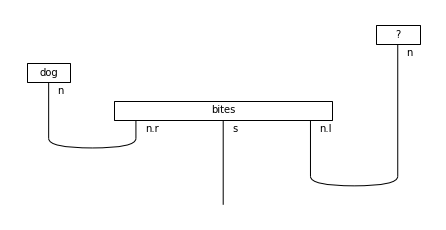

sentence: dog bites ?
prediction: fox | actual: bone

top probabilities:
  fox: 0.99
  cat: 0.01
  fish: 0.00
  chicken: 0.00
------------------



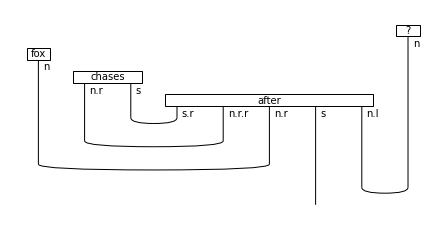

sentence: fox chases after ?
prediction: chicken | actual: chicken

top probabilities:
  chicken: 1.00
  mouse: 0.00
  fish: 0.00
  fox: 0.00
------------------



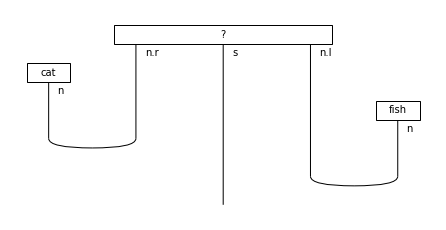

sentence: cat ? fish
prediction: eats | actual: eats

top probabilities:
  eats: 0.60
  bites: 0.35
  flees: 0.05
  chases: 0.00
------------------



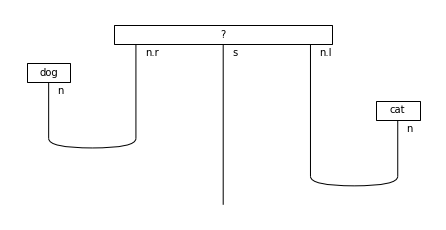

sentence: dog ? cat
prediction: bites | actual: bites

top probabilities:
  bites: 0.81
  flees: 0.18
  eats: 0.01
  chases: 0.00
------------------



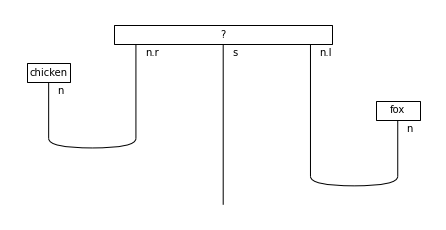

sentence: chicken ? fox
prediction: flees | actual: flees

top probabilities:
  flees: 1.00
  bites: 0.00
  eats: 0.00
  chases: 0.00
------------------



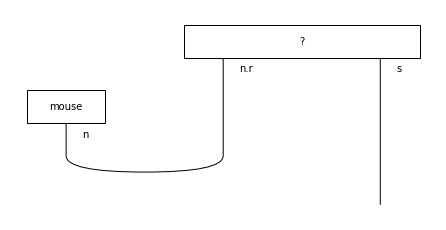

sentence: mouse ?
prediction: clucks | actual: squeaks

top probabilities:
  clucks: 0.59
  chases: 0.22
  swims: 0.07
  squeaks: 0.05
------------------



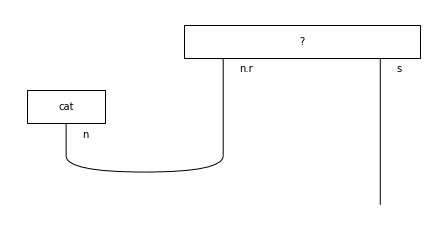

sentence: cat ?
prediction: runs | actual: meows

top probabilities:
  runs: 0.30
  meows: 0.21
  chases: 0.19
  squeaks: 0.11
------------------



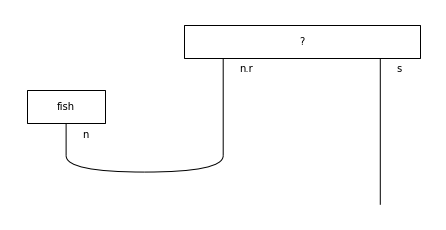

sentence: fish ?
prediction: chases | actual: swims

top probabilities:
  chases: 0.85
  clucks: 0.05
  runs: 0.05
  barks: 0.03
------------------



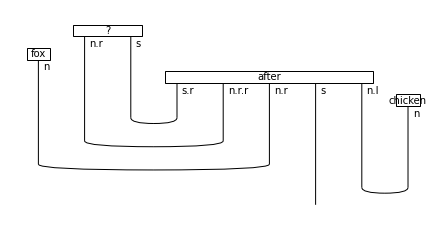

sentence: fox ? after chicken
prediction: chases | actual: chases

top probabilities:
  chases: 1.00
  runs: 0.00
  swims: 0.00
  squeaks: 0.00
------------------



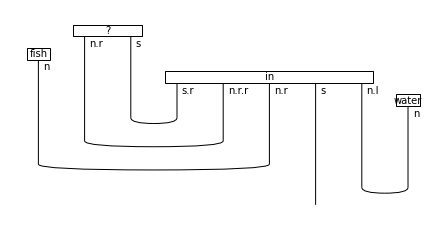

sentence: fish ? in water
prediction: swims | actual: swims

top probabilities:
  swims: 0.97
  runs: 0.02
  barks: 0.01
  squeaks: 0.01
------------------



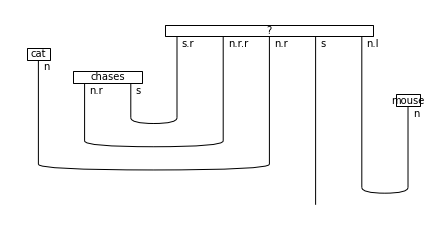

sentence: cat chases ? mouse
prediction: after | actual: after

top probabilities:
  after: 0.99
  on: 0.01
  in: 0.00
  at: 0.00
------------------



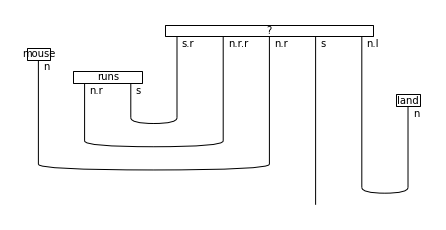

sentence: mouse runs ? land
prediction: on | actual: on

top probabilities:
  on: 1.00
  in: 0.00
  at: 0.00
  after: 0.00
------------------



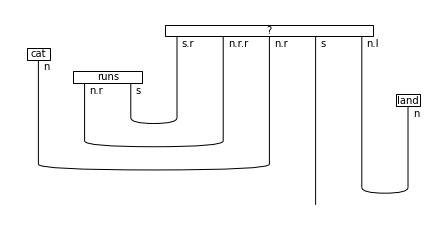

sentence: cat runs ? land
prediction: on | actual: on

top probabilities:
  on: 0.99
  after: 0.01
  in: 0.00
  at: 0.00
------------------



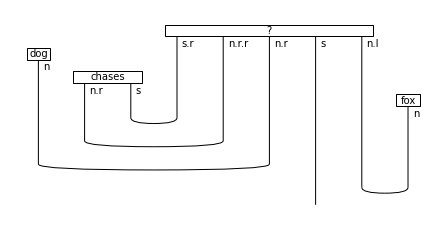

sentence: dog chases ? fox
prediction: after | actual: after

top probabilities:
  after: 1.00
  on: 0.00
  in: 0.00
  at: 0.00
------------------



In [6]:
show_results(flm, test_data)

# Results on Whole Dataset

In [7]:
show_results_compact(flm, train_data, test_data)

? runs after chicken:  fox (fox)
[top probabilities: fox: 0.55, cat: 0.45]
--------------
mouse runs on ?:  dog (land)
[top probabilities: dog: 0.69, land: 0.26]
--------------
seal eats ?:  fish (fish)
[top probabilities: fish: 0.89, cheese: 0.08]
--------------
cat eats ?:  fish (fish)
[top probabilities: fish: 0.77, fox: 0.13]
--------------
? runs after fox:  dog (dog)
[top probabilities: dog: 0.53, water: 0.43]
--------------
dog runs after ?:  fox (fox)
[top probabilities: fox: 0.94, cat: 0.06]
--------------
dog runs on ?:  dog (land)
[top probabilities: dog: 0.92, land: 0.07]
--------------
? swims:  water (seal)
[top probabilities: water: 0.26, dog: 0.14]
--------------
? squeaks:  water (mouse)
[top probabilities: water: 0.27, dog: 0.13]
--------------
chicken eats ?:  cheese (grain)
[top probabilities: cheese: 0.61, grain: 0.18]
--------------
fox chases ?:  cheese (chicken)
[top probabilities: cheese: 0.62, fish: 0.19]
--------------
seal runs on ?:  dog (land)
[top probabi

chicken runs on ?:  land (land)
[top probabilities: land: 0.60, dog: 0.36]
--------------
dog bites ?:  fox (bone)
[top probabilities: fox: 0.99, cat: 0.01]
--------------
fox chases after ?:  chicken (chicken)
[top probabilities: chicken: 1.00, mouse: 0.00]
--------------
cat ? fish:  eats (eats)
[top probabilities: eats: 0.60, bites: 0.35]
--------------
dog ? cat:  bites (bites)
[top probabilities: bites: 0.81, flees: 0.18]
--------------
chicken ? fox:  flees (flees)
[top probabilities: flees: 1.00, bites: 0.00]
--------------
mouse ?:  clucks (squeaks)
[top probabilities: clucks: 0.59, chases: 0.22]
--------------
cat ?:  runs (meows)
[top probabilities: runs: 0.30, meows: 0.21]
--------------
fish ?:  chases (swims)
[top probabilities: chases: 0.85, clucks: 0.05]
--------------
fox ? after chicken:  chases (chases)
[top probabilities: chases: 1.00, runs: 0.00]
--------------
fish ? in water:  swims (swims)
[top probabilities: swims: 0.97, runs: 0.02]
--------------
cat chases ? m